In [1]:
import os
os.chdir('/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/slr/')

import warnings

warnings.filterwarnings('ignore')

import os
os.environ["OMP_NUM_THREADS"] = "1"

from sklearn.svm import SVR

import copy
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from multiprocessing import Pool, cpu_count

normed = True

## Read Data

The next cell reads training, validation, and testing data and explores the contents of the dataset.

In [11]:
gfs_keys = ['slr', 'swe', 'elev'
       'VO1000', 'VO400', 'VO450', 'VO500', 'VO550', 'VO600', 'VO650',
       'VO700', 'VO750', 'VO800', 'VO850', 'VO900', 'VO925', 'VO950',
       'VO975', 'CAPE', 'DIR1000', 'DIR400', 'DIR450', 'DIR500', 'DIR550',
       'DIR600', 'DIR650', 'DIR700', 'DIR750', 'DIR800', 'DIR850',
       'DIR900', 'DIR925', 'DIR950', 'DIR975', 'Z1000', 'Z400', 'Z450',
       'Z500', 'Z550', 'Z600', 'Z650', 'Z700', 'Z750', 'Z800', 'Z850',
       'Z900', 'Z925', 'Z950', 'Z975', 'RH1000', 'RH400', 'RH450',
       'RH500', 'RH550', 'RH600', 'RH650', 'RH700', 'RH750', 'RH800',
       'RH850', 'RH900', 'RH925', 'RH950', 'RH975', 'SP', 'SPD1000',
       'SPD400', 'SPD450', 'SPD500', 'SPD550', 'SPD600', 'SPD650',
       'SPD700', 'SPD750', 'SPD800', 'SPD850', 'SPD900', 'SPD925',
       'SPD950', 'SPD975', 'T1000', '2T', 'T400', 'T450', 'T500', 'T550',
       'T600', 'T650', 'T700', 'T750', 'T800', 'T850', 'T900', 'T925',
       'T950', 'T975', 'TSFC', 'U1000', 'U400', 'U450', 'U500', 'U550',
       'U600', 'U650', 'U700', 'U750', 'U800', 'U850', 'U900', 'U925',
       'U950', 'U975', 'V1000', 'V400', 'V450', 'V500', 'V550', 'V600',
       'V650', 'V700', 'V750', 'V800', 'V850', 'V900', 'V925', 'V950',
       'V975', 'W1000', 'W400', 'W450', 'W500', 'W550', 'W600', 'W650',
       'W700', 'W750', 'W800', 'W850', 'W900', 'W925', 'W950', 'W975']

levs = []
for k in np.unique([k[-3:] for k in gfs_keys]):
    try:
        int(k)
    except:
        pass
    else:
        levs.append(k)
        
levs.append('1000')
np.array(levs, dtype=int)

array([   0,  400,  450,  500,  550,  600,  650,  700,  750,  800,  850,
        900,  925,  950,  975, 1000])

In [27]:
gfs_keys = np.array([k for k in gfs_keys if (('1000' not in k)&('975' not in k) & ('950' not in k)&('925' not in k)&('900' not in k))])
gfs_keys = np.array([k for k in gfs_keys if k[0] not in ['Z', '2', 's', 'C', 'W', 'RH', 'D', 'S']])
# gfs_keys = np.array([k for k in gfs_keys if k[0] not in ['Z', '2', 's', 'C', 'W', 'D', 'S']])
# gfs_keys = np.array([k for k in gfs_keys if k[:2] not in ['VO']])
gfs_keys = np.append('slr', gfs_keys)

df = xr.open_dataset('./data/cln_dataset_untrimmed.nc').load().to_dataframe()
df = [df.rename(columns={k:k.replace('_mean', '') for k in list(df.keys())})][0]
df = df[df['swe'] >= 2.8]
print('full ', df.shape)

# Eliminate events w/ T600 > 0C
tidx = np.where(df['T600_max'] < 273.15)[0]
df = df.iloc[tidx, :]
print('t600 > 0C ', df.shape)

# Eliminate events w/ SLR > x
sidx = np.where(df['slr'] <= 30)[0]
df = df.iloc[sidx, :]
print('slr > 30 ', df.shape)

df = df.loc[:, gfs_keys]
print('nam keys ', df.shape)

df = df.dropna('columns')
print('dropna cols', df.shape)

df = df.dropna('rows')
print('dropna rows', df.shape)

svr_keys = np.array(list(df.keys()))
print(svr_keys)

df.iloc[:5, :]
#df.describe().transpose()

full  (1761, 417)
t600 > 0C  (1755, 417)
slr > 30  (1733, 417)
nam keys  (1733, 52)
dropna cols (1733, 51)
dropna rows (1733, 51)
['slr' 'VO400' 'VO450' 'VO500' 'VO550' 'VO600' 'VO650' 'VO700' 'VO750'
 'VO800' 'VO850' 'RH400' 'RH450' 'RH500' 'RH550' 'RH600' 'RH650' 'RH700'
 'RH750' 'RH800' 'RH850' 'T400' 'T450' 'T500' 'T550' 'T600' 'T650' 'T700'
 'T750' 'T800' 'T850' 'U400' 'U450' 'U500' 'U550' 'U600' 'U650' 'U700'
 'U750' 'U800' 'U850' 'V400' 'V450' 'V500' 'V550' 'V600' 'V650' 'V700'
 'V750' 'V800' 'V850']


,slr,VO400,VO450,VO500,VO550,VO600,VO650,VO700,VO750,VO800,...,V400,V450,V500,V550,V600,V650,V700,V750,V800,V850
time,,,,,,,,,,,,,,,,,,,,,
1999-11-09 11:00:00,9.523810,-0.000073,-0.000031,-0.000003,0.000060,0.000012,-9.861775e-06,0.000003,0.000050,0.000003,...,-18.778061,-17.413544,-15.687195,-11.425934,-8.076843,-4.854355,-3.631500,-1.365112,0.130737,0.164993
1999-11-18 11:00:00,11.320755,0.000130,0.000099,0.000088,0.000092,0.000006,-4.670490e-05,0.000014,0.000122,0.000113,...,-6.593774,-4.578836,-1.525133,0.496761,0.066883,-3.750546,-6.062224,-4.111847,-1.581660,-0.523766
1999-11-20 23:00:00,8.695652,0.000048,0.000043,0.000057,0.000029,-0.000004,-9.913211e-06,0.000018,-0.000028,-0.000068,...,4.493796,5.661245,5.267718,4.058279,2.226746,0.646909,1.246944,1.831198,1.107591,0.276002
1999-11-21 23:00:00,16.071428,0.000047,0.000034,0.000031,0.000032,0.000011,6.655076e-08,0.000053,0.000053,0.000108,...,7.745445,7.049408,4.443125,2.273869,0.110366,-2.030713,-2.323663,-1.806241,-1.461508,-0.647761
1999-11-22 11:00:00,25.000000,0.000152,0.000077,0.000017,-0.000013,-0.000014,-2.196154e-05,0.000040,0.000181,0.000213,...,5.626026,3.388332,0.345156,-3.597740,-6.351337,-7.735167,-7.993655,-5.992301,-2.844563,-1.160246


In [28]:
# n = len(df)
# fig, ax = plt.subplots(1, facecolor='w', figsize=(12, 12))
# ax.hist(df['slr'].values, bins=np.arange(0, 30, 2), edgecolor='k', zorder=100)
# ax.grid()
# ax.set_title('n = %d'%n)
# # ax.set_ylim([0, 30])
# ax.set_xlim([0, 40])
# plt.suptitle('Alta Collins 99-19 Record Obtained from DOT\n(12-hourly)')
# plt.show()

In [29]:
# Split into test/train (+validate) sets
test_size = 0.2 #(0.1:0.112, 0.2:0.25, 0.3:0.43)
X_train, X_test, y_train, y_test = train_test_split(df, df['slr'], test_size=test_size)
print('Train: {}\nTest: {}\nValidate: {}'.format(y_train.shape, y_test.shape, None))

# X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.25)
# print('Test: {}\nTrain: {}\nValidate: {}'.format(y_train.shape, y_validate.shape, y_test.shape))

Train: (1386,)
Test: (347,)
Validate: None


In [30]:
# plt.figure(figsize=(12, 9))
# sns.pairplot(df, diag_kind='kde')
# sns.set_style("white")
# # plt.savefig('./tempcorr_era5_clnSLR.png')
# plt.show()

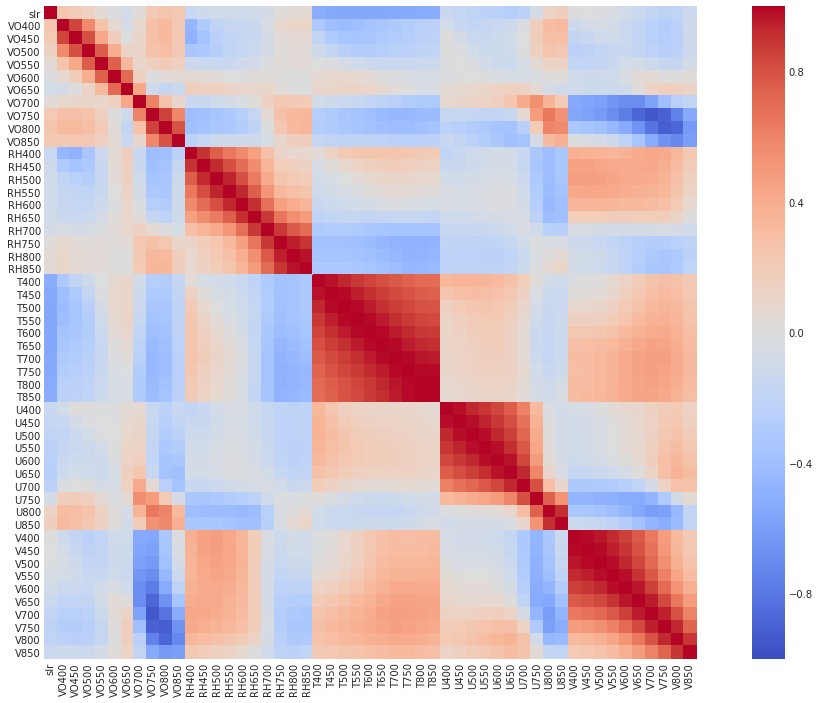

In [31]:
#correlation matrix
sns.set_style("white")
corrmat = X_train.corr()
f, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(corrmat, vmin=-1, vmax=1.0, cmap='coolwarm', square=True)
# plt.savefig('./tempcorrMesh_era5_clnSLR.png')

plt.show()

In [32]:
train_stats = X_train.describe()
train_stats.pop('slr')
train_stats = train_stats.transpose()

train_stats[:]

,count,mean,std,min,25%,50%,75%,max
VO400,1386.0,0.000037,0.000064,-0.000101,-0.000009,0.000026,0.000068,0.000313
VO450,1386.0,0.000031,0.000055,-0.000137,-0.000007,0.000022,0.000061,0.000355
VO500,1386.0,0.000023,0.000044,-0.000109,-0.000006,0.000017,0.000045,0.000240
VO550,1386.0,0.000017,0.000040,-0.000112,-0.000010,0.000011,0.000038,0.000208
VO600,1386.0,0.000015,0.000040,-0.000136,-0.000011,0.000011,0.000037,0.000215
VO650,1386.0,0.000020,0.000045,-0.000162,-0.000008,0.000016,0.000044,0.000233
VO700,1386.0,0.000039,0.000067,-0.000303,0.000002,0.000045,0.000083,0.000250
VO750,1386.0,0.000007,0.000158,-0.000550,-0.000095,0.000031,0.000124,0.000421
VO800,1386.0,-0.000034,0.000170,-0.000472,-0.000158,-0.000011,0.000094,0.000361
VO850,1386.0,-0.000004,0.000032,-0.000115,-0.000026,-0.000004,0.000018,0.000115


In [33]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

y_train = X_train.pop('slr')
y_test = X_test.pop('slr')

X_train_norm = norm(X_train) if normed else X_train
X_test_norm = norm(X_test) if normed else X_test

train_stats_norm = X_train_norm.describe()
train_stats_norm = train_stats_norm.transpose()
train_stats_norm

,count,mean,std,min,25%,50%,75%,max
VO400,1386.0,6.105820e-07,1.000000,-2.164176,-0.722600,-0.183456,0.472366,4.319835
VO450,1386.0,-2.004023e-08,1.000000,-3.020350,-0.674998,-0.150986,0.540084,5.850844
VO500,1386.0,-3.102366e-07,1.000000,-2.961161,-0.660730,-0.134818,0.494483,4.871041
VO550,1386.0,-1.519359e-07,1.000000,-3.196500,-0.669616,-0.130716,0.528202,4.766430
VO600,1386.0,-3.941819e-07,1.000000,-3.819770,-0.651364,-0.107530,0.548963,5.053067
VO650,1386.0,-7.138796e-08,1.000000,-4.010951,-0.611195,-0.069736,0.546030,4.708783
VO700,1386.0,1.745995e-08,1.000000,-5.058211,-0.538781,0.092373,0.661759,3.130432
VO750,1386.0,-1.204134e-09,1.000000,-3.537038,-0.651469,0.149730,0.740645,2.628388
VO800,1386.0,-1.565374e-08,1.000000,-2.575998,-0.726976,0.133607,0.753261,2.323440
VO850,1386.0,8.635363e-08,1.000000,-3.426056,-0.663230,0.008966,0.706548,3.684662


In [34]:
def SVR_mp(_params):
    
    print('.', end='')
    
    _i, _j, _C, _e = _params
    
    _model = SVR(
                C=_C, #Ridge regularization parameter for (L2)^2 penalty
                epsilon=_e, #Specifies the epsilon-tube within which no penalty is associated in the training loss function
                kernel='rbf', #'linear', 'polynomial' 
                degree=3, #pass interger for 'polynomial' kernel, ignored otherwise
                tol=0.001, #stopping tolerance
                shrinking=True, 
                cache_size=200, 
                verbose=False)
        
    _model.fit(X_train_norm, y_train)
    
    test_predictions = _model.predict(X_test_norm).flatten()
    _r2 = sklearn.metrics.r2_score(y_test.values.flatten(), test_predictions)
    _mse = sklearn.metrics.mean_squared_error(y_test.values.flatten(), test_predictions)
    _mae = sklearn.metrics.mean_absolute_error(y_test.values.flatten(), test_predictions)
    
    return (_i, _j, _C, _e, _r2, _mae, _mse, _model)

# Best test
# crange = np.arange(50.0, 100.1, .1)
# erange = np.arange(0.0, 1.1, .01)

# General Experiment
crange = np.arange(1., 100.1, 1.)
erange = np.arange(0., 4., .1)

# T preds only
# crange = np.arange(60.0, 65.1, .01)
# erange = np.arange(0.4, 0.6, .01)

params = {}
params['r2'] = np.zeros((len(crange), len(erange)))
params['mae'] = np.zeros((len(crange), len(erange)))
params['mse'] = np.zeros((len(crange), len(erange)))
params['model'] = np.empty((len(crange), len(erange)), dtype='object')
params['epsilon'] = np.zeros((len(crange), len(erange)))
params['C'] = np.zeros((len(crange), len(erange)))

mp_params = np.array([[(i, j, C, e) for j, e in enumerate(erange)] 
                      for i, C in enumerate(crange)]).reshape(-1, 4)

print('Iterations to attempt: %d'%len(mp_params))

# Paralellize here
# mp_returns = [SVR_mp(_param) for _param in mp_params[:10]]
with Pool(64) as p:
    mp_returns = p.map(SVR_mp, mp_params, chunksize=1)
    p.close()
    p.join()

for item in mp_returns:
    
    i, j, C, e, r2, mae, mse, model = item
    i, j = int(i), int(j)
        
    params['r2'][i, j] = r2
    params['mse'][i, j] = mse
    params['mae'][i, j] = mae
    params['model'][i, j] = model
    params['epsilon'][i, j] = e
    params['C'][i, j] = C

Iterations to attempt: 4000
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

MARE  0.18847594521740252


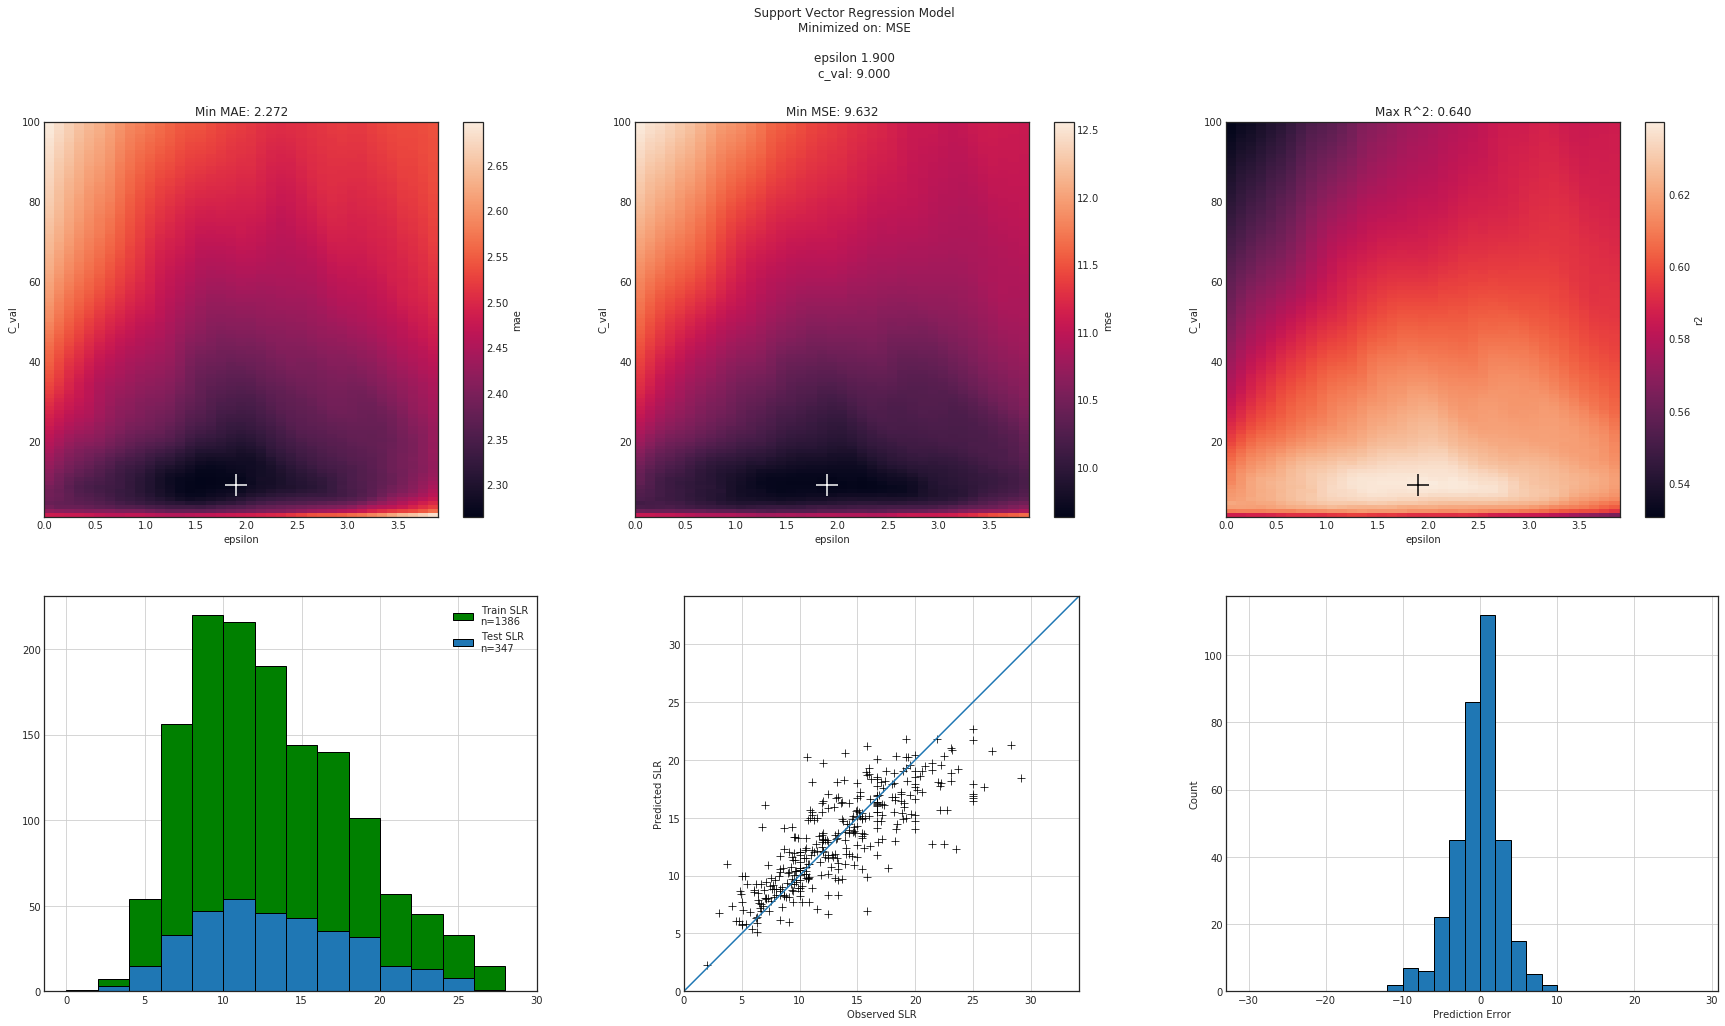

MARE  0.18666926996688635


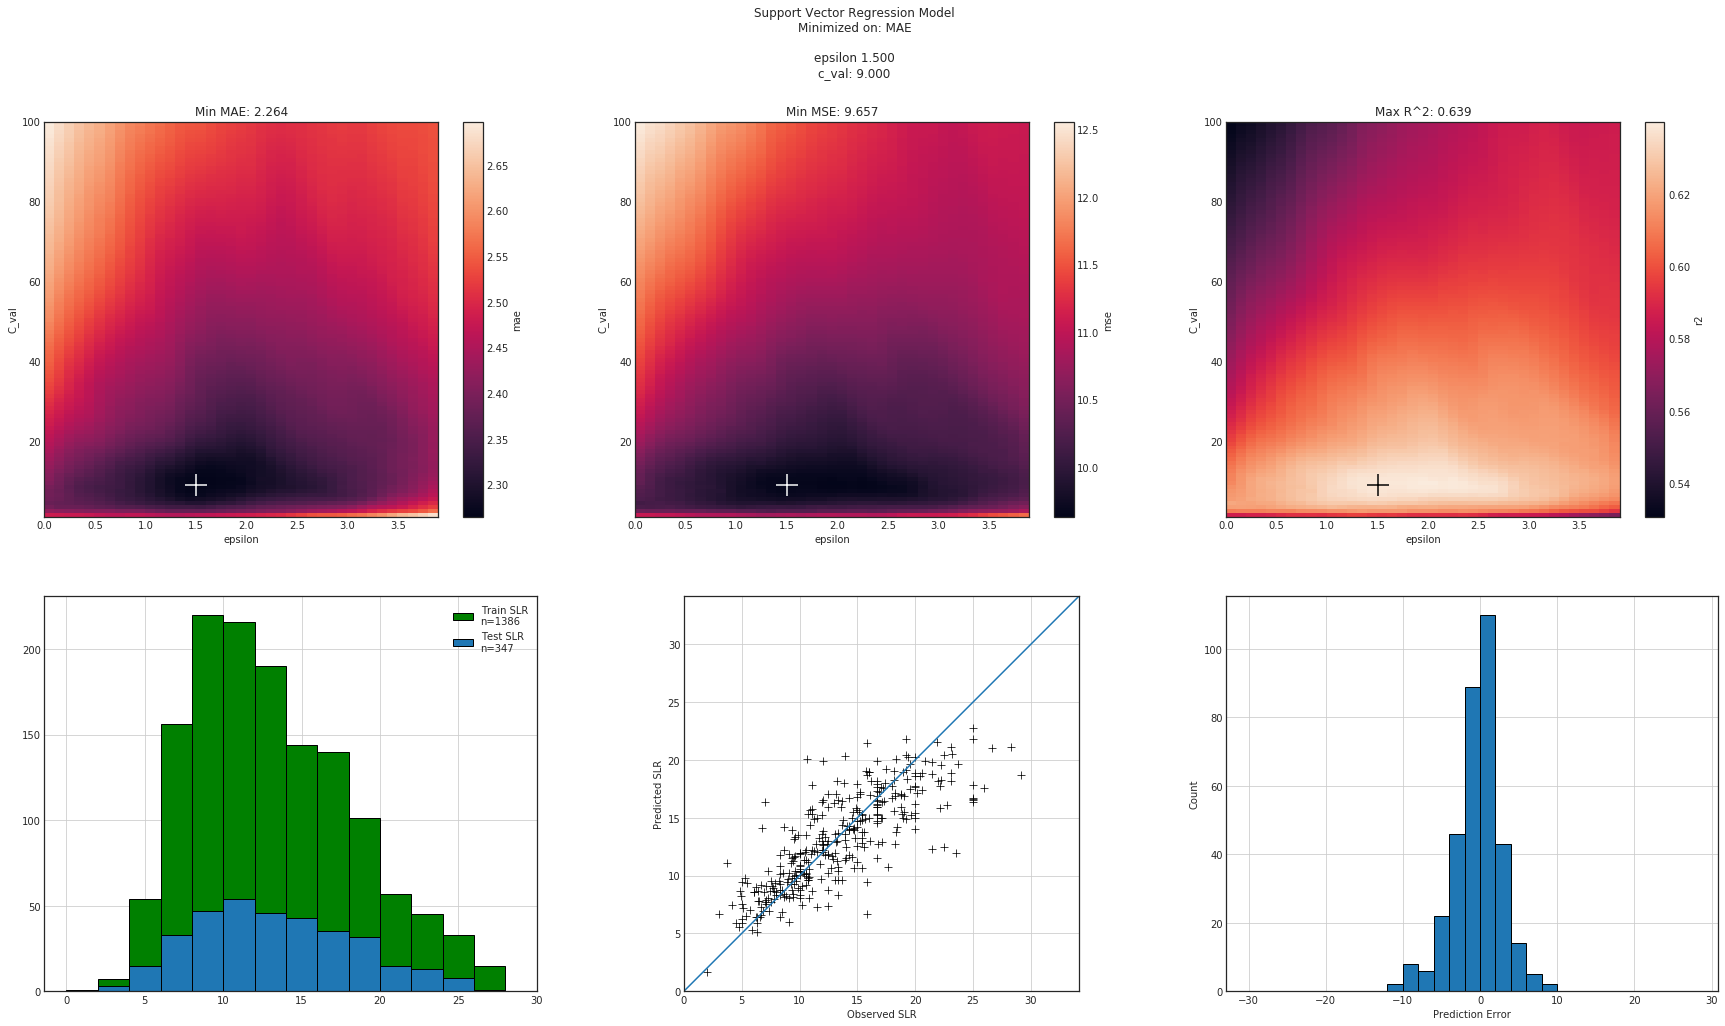

MARE  0.18847594521740252


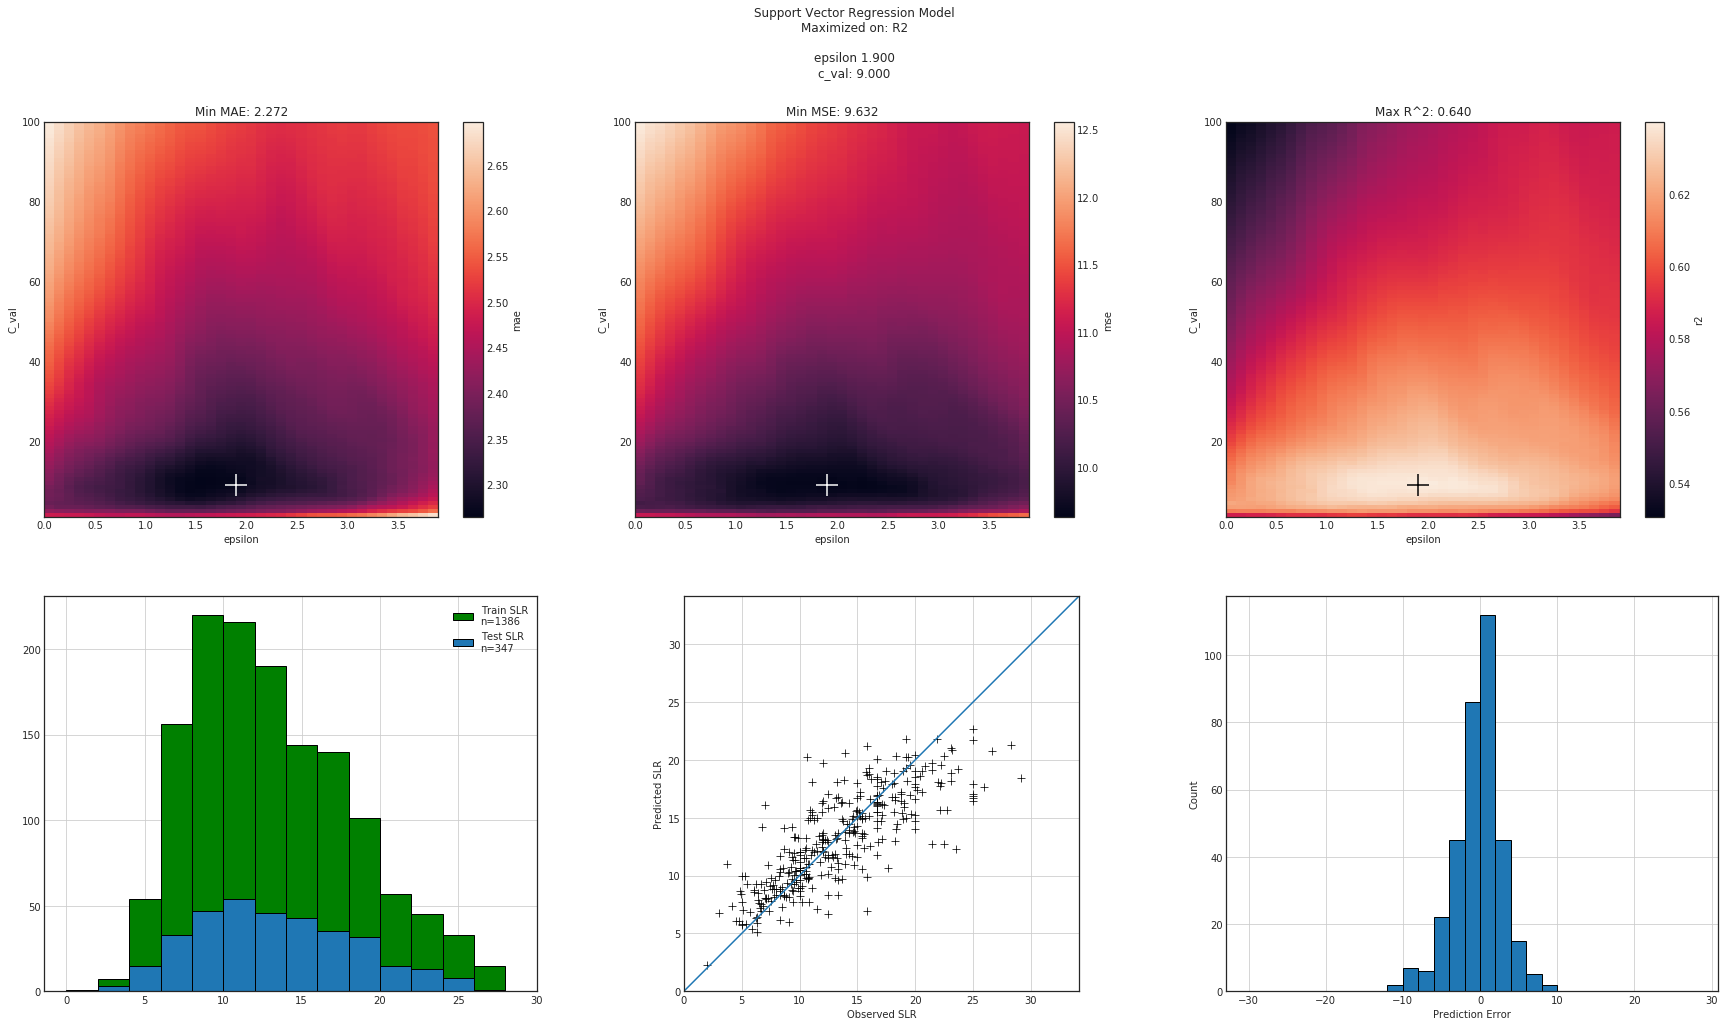

In [35]:
min_on, indexer, _ = 'R2', np.where(params['r2'] == params['r2'].max()), params['r2'].max()
min_on, indexer, _ = 'MAE', np.where(params['mae'] == params['mae'].min()), params['mae'].min()
min_on, indexer, _ = 'MSE', np.where(params['mse'] == params['mse'].min()), params['mse'].min()

def MARE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

for min_on in ['mse', 'mae', 'r2']:
    
    if min_on in ['mse', 'mae']:
        min_max = 'Minimized'
        indexer = np.where(params[min_on] == params[min_on].min())
    elif min_on in ['r2']:
        min_max = 'Maximized'
        indexer = np.where(params[min_on] == params[min_on].max())

    r, c = indexer
    r, c = r[0], c[0]
    r, c, _

    model = params['model'][r, c]
    test_predictions = model.predict(X_test_norm)
    
    y_true = y_test
    y_pred = test_predictions
    print('MARE ', MARE(y_true, y_pred))

    fig, axs = plt.subplots(2, 3, figsize=(30, 16))
    axs = axs.flatten()

    ax = axs[0]
    cbar = ax.pcolormesh(erange, crange, params['mae'])
    plt.colorbar(cbar, label='mae', ax=ax)
    ax.set_title('Min MAE: %.3f'%params['mae'][r, c])
    ax.scatter(params['epsilon'][r, c], params['C'][r, c], s=500, c='w', marker='+')

    ax = axs[1]
    cbar = ax.pcolormesh(erange, crange, params['mse'])
    plt.colorbar(cbar, label='mse', ax=ax)
    ax.set_title('Min MSE: %.3f'%params['mse'][r, c])
    ax.scatter(params['epsilon'][r, c], params['C'][r, c], s=500, c='w', marker='+')

    ax = axs[2]
    cbar = ax.pcolormesh(erange, crange, params['r2'])
    plt.colorbar(cbar, label='r2', ax=ax)
    ax.set_title('Max R^2: %.3f'%params['r2'][r, c])
    ax.scatter(params['epsilon'][r, c], params['C'][r, c], s=500, c='k', marker='+')

    for ax in axs[:3]:
        ax.set_xlabel('epsilon')
        ax.set_ylabel('C_val')
        ax.set_ylim([crange.min(), crange.max()])
        ax.set_xlim([erange.min(), erange.max()])

    ax = axs[3]
    maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

    ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
    ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Test SLR\nn=%d'%len(y_test))
    ax.legend()

    ax.set_xticks(np.arange(0, maxslr+1, 5))
    ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
    ax.grid()

    ax = axs[4]
    maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
    maxslr += 5
    ax.scatter(y_test, test_predictions, c='k', s=50, marker='+', linewidth=0.75)
    ax.set_xlabel('Observed SLR')
    ax.set_ylabel('Predicted SLR')
    ax.plot([0, maxslr], [0, maxslr])
    ax.set_xlim([0, maxslr])
    ax.set_ylim([0, maxslr])
    ax.set_aspect('equal')
    ax.grid()

    ax = axs[5]
    error = test_predictions - y_test
    ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
    ax.set_xlabel('Prediction Error')
    ax.set_ylabel('Count')
    ax.grid()

    plt.suptitle('Support Vector Regression Model\n%s on: %s\n\nepsilon %.3f\nc_val: %.3f'%(min_max, min_on.upper(), params['epsilon'][r, c], params['C'][r, c]))
    plt.show()

MARE  0.18847594521740252


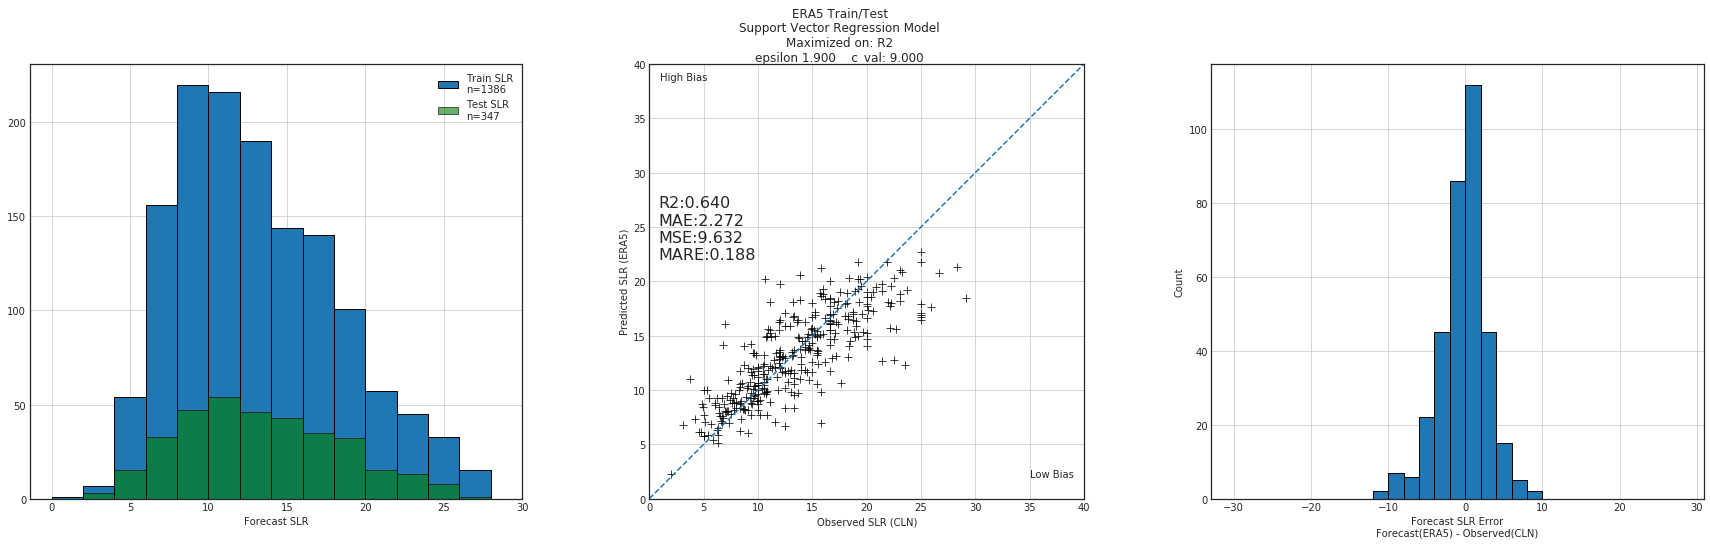

In [47]:
min_on, indexer, _ = 'R2', np.where(params['r2'] == params['r2'].max()), params['r2'].max()
min_on, indexer, _ = 'MAE', np.where(params['mae'] == params['mae'].min()), params['mae'].min()
min_on, indexer, _ = 'MSE', np.where(params['mse'] == params['mse'].min()), params['mse'].min()

def MARE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

for min_on in ['r2']:#, 'mae', 'r2']:
    
    if min_on in ['mse', 'mae']:
        min_max = 'Minimized'
        indexer = np.where(params[min_on] == params[min_on].min())
    elif min_on in ['r2']:
        min_max = 'Maximized'
        indexer = np.where(params[min_on] == params[min_on].max())

    r, c = indexer
    r, c = r[0], c[0]
    r, c, _

    model = params['model'][r, c]
    test_predictions = model.predict(X_test_norm)
    
    y_true = y_test
    y_pred = test_predictions
    print('MARE ', MARE(y_true, y_pred))

    r2 = params['r2'][r, c]
    mae = params['mae'][r, c]
    mse = params['mse'][r, c]
    mare = MARE(y_true, y_pred)
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    axs = axs.flatten()

    ax = axs[0]
    maxslr = y_test.max() if y_test.max() > y_train.max() else y_train.max()

    ax.hist(y_train, bins=np.arange(0, maxslr, 2), color='C0', edgecolor='k', alpha=1.0, label='Train SLR\nn=%d'%len(y_train))
    ax.hist(y_test, bins=np.arange(0, maxslr, 2), color='g', edgecolor='k', alpha=0.6, label='Test SLR\nn=%d'%len(y_test))
    ax.legend()

    ax.set_xlabel('Forecast SLR')
    ax.set_xticks(np.arange(0, maxslr+1, 5))
    ax.set_xticklabels(np.arange(0, maxslr+1, 5).astype(int))
    ax.grid()

    ax = axs[1]
    maxslr = test_predictions.max() if test_predictions.max() > y_test.max() else y_test.max()
    maxslr += 5
    ax.scatter(y_test, test_predictions, c='k', s=50, marker='+', linewidth=0.75)
    ax.set_xlabel('Observed SLR (CLN)')
    ax.set_ylabel('Predicted SLR (ERA5)')
    ax.plot([0, 40], [0, 40], '--')
    ax.set_xlim([0, 40])
    ax.set_ylim([0, 40])
    ax.set_aspect('equal')
    ax.grid()
    
    max_slr = max(max(y_test), max(y_train))
    ax.text(1, 40-1.5, 'High Bias')
    ax.text(40-5, 2, 'Low Bias')
    ax.text(.8, 22, 'R2:%.3f\nMAE:%.3f\nMSE:%.3f\nMARE:%.3f'%(r2, mae, mse, mare), fontsize=16)

    ax = axs[2]
    error = test_predictions - y_test
    ax.hist(error, bins=np.arange(-30, 30, 2), edgecolor='k')
    ax.set_xlabel('Forecast SLR Error\nForecast(ERA5) - Observed(CLN)')
    ax.set_ylabel('Count')
    ax.grid()

    plt.suptitle('ERA5 Train/Test\nSupport Vector Regression Model\n%s on: %s\nepsilon %.3f    c_val: %.3f'%(min_max, min_on.upper(), params['epsilon'][r, c], params['C'][r, c]))
    plt.show()

In [37]:
svr_keys = np.array(list(X_test_norm.keys()))
svr_model = model
norm_mu = train_stats['mean']
norm_std = train_stats['std']

np.save('./data/svr_export.npy', 
        [svr_keys, svr_model, norm_mu, norm_std], allow_pickle=True)

In [38]:
svr_keys

array(['VO400', 'VO450', 'VO500', 'VO550', 'VO600', 'VO650', 'VO700',
       'VO750', 'VO800', 'VO850', 'RH400', 'RH450', 'RH500', 'RH550',
       'RH600', 'RH650', 'RH700', 'RH750', 'RH800', 'RH850', 'T400',
       'T450', 'T500', 'T550', 'T600', 'T650', 'T700', 'T750', 'T800',
       'T850', 'U400', 'U450', 'U500', 'U550', 'U600', 'U650', 'U700',
       'U750', 'U800', 'U850', 'V400', 'V450', 'V500', 'V550', 'V600',
       'V650', 'V700', 'V750', 'V800', 'V850'], dtype='<U5')

In [39]:
svr_model


SVR(C=9.0, cache_size=200, coef0=0.0, degree=3, epsilon=1.9000000000000001,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)